
# Cross-Validation 101: **Classification & Time Series** (scikit-learn)

**Audience:** Entry–to–mid level  
**Goal:** Learn how to evaluate models properly with cross-validation for both *classification* and *time series* tasks in scikit-learn, avoid data leakage, and choose models/hyperparameters safely.

## Learning Objectives
By the end you will be able to:
1. Explain why a single train/test split can be misleading.
2. Use **KFold** and **StratifiedKFold** for classification.
3. Avoid **data leakage** by placing preprocessing steps (e.g., scaling) **inside** a `Pipeline`.
4. Tune hyperparameters with `GridSearchCV` and understand **nested cross-validation**.
5. Understand **why time series needs special CV** and use `TimeSeriesSplit` for expanding/rolling validation.
6. Build simple **lag features** and evaluate a forecasting model with walk-forward validation.



## 0) Setup
Install/import packages and set up utilities.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, make_scorer

np.random.seed(42)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)



---
# Part A — Classification Cross-Validation

We'll use the classic **Iris** dataset and a few simple models to see how CV works and how to avoid leakage.



### 1) Load data


In [2]:

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0



### 2) Quick baseline with a single train/test split (for intuition)

A single split is easy but **high-variance**. We'll still do it once to get a baseline.


In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
print("Baseline test accuracy:", clf.score(X_test, y_test))


Baseline test accuracy: 0.9666666666666667



### 3) KFold vs **StratifiedKFold**

- **KFold** splits data into K roughly equal folds, but class proportions can vary per fold.
- **StratifiedKFold** keeps class proportions similar across folds — better for classification.


In [4]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_kf = cross_val_score(LogisticRegression(max_iter=1000), X, y, cv=kf, scoring='accuracy')
scores_skf = cross_val_score(LogisticRegression(max_iter=1000), X, y, cv=skf, scoring='accuracy')

print("KFold    accuracy per fold:", np.round(scores_kf, 3))
print("KFold    mean±std:", np.round(scores_kf.mean(), 3), "±", np.round(scores_kf.std(), 3))
print("StratifiedKFold accuracy per fold:", np.round(scores_skf, 3))
print("StratifiedKFold mean±std:", np.round(scores_skf.mean(), 3), "±", np.round(scores_skf.std(), 3))


KFold    accuracy per fold: [1.    1.    0.933 0.967 0.967]
KFold    mean±std: 0.973 ± 0.025
StratifiedKFold accuracy per fold: [1.    0.967 0.933 1.    0.933]
StratifiedKFold mean±std: 0.967 ± 0.03



### 4) **Data leakage** demo: scaling outside vs inside a `Pipeline`

**Wrong**: Fit `StandardScaler` on the *entire* dataset and then cross-validate → information from the test folds leaks into training.

**Right**: Put `StandardScaler` *inside* a `Pipeline`, so it's fit **inside each fold** only on training data.


In [5]:

# WRONG: scaling on the full dataset before CV (leakage)
X_scaled_wrong = StandardScaler().fit_transform(X)  # fitted on full data (includes test folds!)
scores_wrong = cross_val_score(LogisticRegression(max_iter=1000), X_scaled_wrong, y, cv=skf, scoring='accuracy')

# RIGHT: scaling inside a Pipeline (no leakage)
pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000))])
scores_right = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy')

print("WRONG (leaky) CV scores:", np.round(scores_wrong, 3))
print("RIGHT (pipeline) CV scores:", np.round(scores_right, 3))


WRONG (leaky) CV scores: [1.    0.967 0.9   1.    0.9  ]
RIGHT (pipeline) CV scores: [1.    0.967 0.9   1.    0.9  ]



### 5) Inspect cross-validated predictions with a confusion matrix

`cross_val_predict` gives **out-of-fold** predictions for each sample (each sample is predicted by a model that **never saw it** during training).


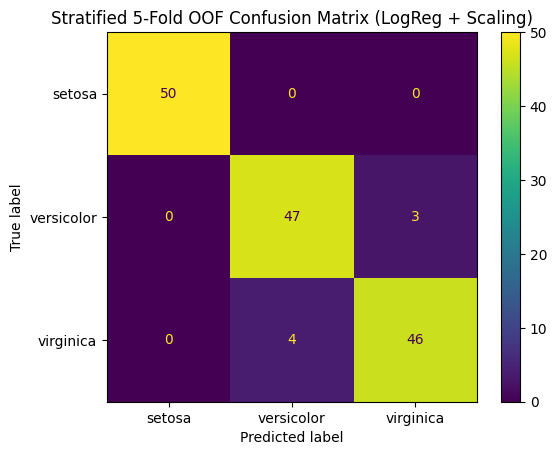

In [6]:

y_pred_oof = cross_val_predict(pipe, X, y, cv=skf)
cm = confusion_matrix(y, y_pred_oof, labels=np.unique(y))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot()
plt.title("Stratified 5-Fold OOF Confusion Matrix (LogReg + Scaling)")
plt.show()



### 6) Hyperparameter search with `GridSearchCV` and **Nested CV (optional)**

We use an SVM with RBF kernel and tune `C`/`gamma`.  
- **GridSearchCV**: finds best params on **inner** CV.
- **Nested CV**: wraps the search with an **outer** CV to estimate generalization performance without overfitting to the inner CV.


In [7]:

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto', 0.1, 0.01]
}

gscv = GridSearchCV(pipe_svc, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
nested_scores = cross_val_score(gscv, X, y, cv=outer_cv, scoring='accuracy')

print("Nested CV accuracy per outer fold:", np.round(nested_scores, 3))
print("Nested CV mean±std:", np.round(nested_scores.mean(), 3), "±", np.round(nested_scores.std(), 3))

# (Optional) Fit once on the full dataset to see the chosen best params
gscv.fit(X, y)
print("Best params found (full-data fit for illustration):", gscv.best_params_)


Nested CV accuracy per outer fold: [1.    0.967 0.933 1.    0.9  ]
Nested CV mean±std: 0.96 ± 0.039
Best params found (full-data fit for illustration): {'svc__C': 1, 'svc__gamma': 'scale'}



---
# Part B — Time Series Cross-Validation

For time series, **order matters**. Randomly shuffling or using standard KFold can leak future information into the past.  
We will:
1. Generate a synthetic monthly series with trend + seasonality.
2. Build **lag features** (previous months) to predict the next value.
3. Use **TimeSeriesSplit** (expanding window).
4. Do a simple **walk-forward** forecast and plot results.



### 1) Create a synthetic monthly time series (10 years)


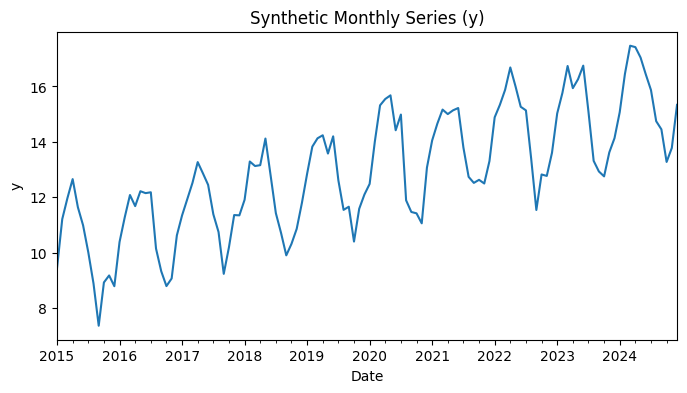

,y
date,
2015-01-01,9.444060
2015-02-01,11.209451
2015-03-01,11.971571
2015-04-01,12.655258
2015-05-01,11.641612


In [8]:

# 10 years of monthly data
dates = pd.date_range(start="2015-01-01", periods=120, freq="MS")
t = np.arange(len(dates))

# Trend + seasonal + noise
trend = 0.05 * t
seasonal = 2 * np.sin(2 * np.pi * t / 12)
noise = np.random.normal(0, 0.5, size=len(t))

y_series = 10 + trend + seasonal + noise

ts = pd.DataFrame({"y": y_series}, index=dates)
ts.index.name = "date"

ax = ts["y"].plot(figsize=(8, 4))
ax.set_title("Synthetic Monthly Series (y)")
ax.set_xlabel("Date")
ax.set_ylabel("y")
plt.show()

ts.head()



### 2) Create **lag features**

We use the past 12 months as predictors for the next month's value.


In [9]:

def add_lag_features(df, target_col="y", n_lags=12):
    data = df.copy()
    for lag in range(1, n_lags + 1):
        data[f"lag_{lag}"] = data[target_col].shift(lag)
    return data

ts_lag = add_lag_features(ts, "y", n_lags=12).dropna()
X_ts = ts_lag.drop(columns=["y"]).values
y_ts = ts_lag["y"].values

ts_lag.head(15)


,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
date,,,,,,,,,,,,,
2016-01-01,10.385977,8.788062,9.176172,8.925185,7.361675,8.887959,10.014310,10.987415,11.641612,12.655258,11.971571,11.209451,9.444060
2016-02-01,11.278797,10.385977,8.788062,9.176172,8.925185,7.361675,8.887959,10.014310,10.987415,11.641612,12.655258,11.971571,11.209451
2016-03-01,12.080379,11.278797,10.385977,8.788062,9.176172,8.925185,7.361675,8.887959,10.014310,10.987415,11.641612,12.655258,11.971571
2016-04-01,11.680190,12.080379,11.278797,10.385977,8.788062,9.176172,8.925185,7.361675,8.887959,10.014310,10.987415,11.641612,12.655258
2016-05-01,12.217313,11.680190,12.080379,11.278797,10.385977,8.788062,9.176172,8.925185,7.361675,8.887959,10.014310,10.987415,11.641612
2016-06-01,12.148860,12.217313,11.680190,12.080379,11.278797,10.385977,8.788062,9.176172,8.925185,7.361675,8.887959,10.014310,10.987415
2016-07-01,12.179744,12.148860,12.217313,11.680190,12.080379,11.278797,10.385977,8.788062,9.176172,8.925185,7.361675,8.887959,10.014310
2016-08-01,10.147117,12.179744,12.148860,12.217313,11.680190,12.080379,11.278797,10.385977,8.788062,9.176172,8.925185,7.361675,8.887959
2016-09-01,9.329059,10.147117,12.179744,12.148860,12.217313,11.680190,12.080379,11.278797,10.385977,8.788062,9.176172,8.925185,7.361675



### 3) Why not standard KFold here?

Because it can mix **future** samples into the **training** folds for earlier predictions, causing **leakage** and over-optimistic scores.  
We won't run it here (or we'll keep it as a cautionary example), but you can try and compare:


In [10]:

# CAUTION: This is shown for comparison only. Not recommended for time series!
kf = KFold(n_splits=5, shuffle=True, random_state=42)
bad_scores = cross_val_score(LinearRegression(), X_ts, y_ts, cv=kf, scoring='neg_mean_absolute_error')
print("BAD (leaky) KFold MAE (neg):", np.round(bad_scores, 3), "-> higher is better because it's negative MAE")
print("BAD (leaky) KFold MAE (mean):", np.round(-bad_scores.mean(), 3))


BAD (leaky) KFold MAE (neg): [-0.47  -0.498 -0.469 -0.56  -0.412] -> higher is better because it's negative MAE
BAD (leaky) KFold MAE (mean): 0.482



### 4) Correct approach: `TimeSeriesSplit` (expanding window)

Each fold trains on the **past** and validates on the **future** only.


In [11]:

tscv = TimeSeriesSplit(n_splits=5)

pipe_ts = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # negative for cross_val_score

scores_ts = cross_val_score(pipe_ts, X_ts, y_ts, cv=tscv, scoring=mae_scorer)
print("TimeSeriesSplit MAE (neg):", np.round(scores_ts, 3))
print("TimeSeriesSplit MAE (mean):", np.round(-scores_ts.mean(), 3))


TimeSeriesSplit MAE (neg): [-0.448 -0.547 -0.488 -0.439 -0.378]
TimeSeriesSplit MAE (mean): 0.46



#### Peek at the fold sizes


In [12]:

for i, (tr, va) in enumerate(tscv.split(X_ts)):
    print(f"Fold {i+1}: train={len(tr)} validate={len(va)}")


Fold 1: train=18 validate=18
Fold 2: train=36 validate=18
Fold 3: train=54 validate=18
Fold 4: train=72 validate=18
Fold 5: train=90 validate=18



### 5) Walk-forward (rolling) forecast for the last 12 months

We'll simulate **forecasting one month ahead** repeatedly.  
At each step, we fit on all data **up to** that month and predict the **next** month.


Walk-forward MAE: 0.400
Walk-forward MAPE: 2.60%


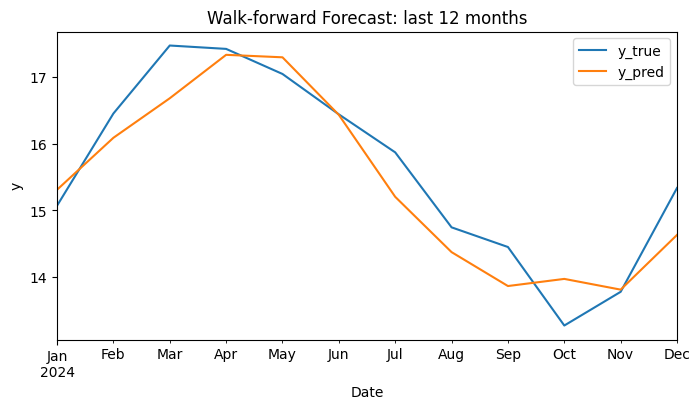

,y_true,y_pred
date,,
2024-01-01,15.070409,15.309384
2024-02-01,16.451969,16.088205
2024-03-01,17.470928,16.680517
2024-04-01,17.420486,17.331466
2024-05-01,17.044696,17.294329
2024-06-01,16.439251,16.431812
2024-07-01,15.869910,15.203699
2024-08-01,14.746310,14.374889
2024-09-01,14.451598,13.866865


In [13]:

# We'll predict the last 12 available targets, one step at a time
horizon = 12

# Indices relative to X_ts/y_ts (which already dropped the first 12 rows for lags)
n = len(y_ts)
start_pred_idx = n - horizon  # first index to predict (predict y of this index using previous data)

# Prepare a pipeline
pipe_wf = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])

preds = []
actuals = []
pred_index = []

for i in range(start_pred_idx, n):
    # Train on everything strictly before i
    tr_idx = np.arange(0, i)
    te_idx = np.array([i])
    pipe_wf.fit(X_ts[tr_idx], y_ts[tr_idx])
    y_hat = pipe_wf.predict(X_ts[te_idx])[0]

    preds.append(y_hat)
    actuals.append(y_ts[i])
    # Map back to the original timestamp
    pred_index.append(ts_lag.index[i])

wf_df = pd.DataFrame({"y_true": actuals, "y_pred": preds}, index=pd.Index(pred_index, name="date"))

mae = mean_absolute_error(wf_df["y_true"], wf_df["y_pred"])
mape = (np.abs((wf_df["y_true"] - wf_df["y_pred"]) / wf_df["y_true"]).mean()) * 100

print(f"Walk-forward MAE: {mae:.3f}")
print(f"Walk-forward MAPE: {mape:.2f}%")

ax = wf_df.plot(figsize=(8, 4))
ax.set_title("Walk-forward Forecast: last 12 months")
ax.set_xlabel("Date")
ax.set_ylabel("y")
plt.show()

wf_df.head(12)



---
## Exercises

**Classification:**
1. Replace Logistic Regression with `SVC` or `RandomForestClassifier`. Compare **`KFold` vs `StratifiedKFold`** scores.
2. Add polynomial features via `sklearn.preprocessing.PolynomialFeatures` and compare CV scores (keep it inside the `Pipeline`).
3. Try different `n_splits` values (e.g., 3, 10). How do mean and std of accuracy change?

**Time Series:**
1. Change the number of lags from 12 to 3 and 24. What happens to CV and walk-forward errors?
2. Swap `Ridge` with `LinearRegression` or `RandomForestRegressor`. Compare `TimeSeriesSplit` scores.
3. Try a **rolling-window** fit instead of expanding: only keep the most recent 60 months for training at each step.
4. Build a simple **baseline** predictor (e.g., predict the last observed value). How does it compare to Ridge?

**Optional (Mid-level):**
- Implement **nested CV** for the time series with an inner `GridSearchCV` (using `TimeSeriesSplit`) and outer `TimeSeriesSplit` for scoring.
- Create a custom scorer (e.g., symmetric mean absolute percentage error, sMAPE).



---
## Tips & Common Pitfalls
- Always keep **preprocessing inside the Pipeline** during CV.
- For classification, prefer **StratifiedKFold** (especially with class imbalance).
- For time series, use **TimeSeriesSplit** or manual walk-forward methods.
- Report **mean ± std** across folds; don't cherry-pick a single fold.
- Compare to a **simple baseline** to justify model complexity.

---
*Happy learning!* 🎓
